In [1]:
!pip install tensorflow==2.3

In [21]:
!pip install retry

     |████████████████████████████████| 97 kB 2.2 MB/s eta 0:00:01


Using https://www.kaggle.com/cyannani123/keras-cellular-image-classification as test example

In [1]:
import os

In [2]:
import sys

In [3]:
sys.executable

'/home/kaur/miniconda3/envs/kaggle_recbio_3/bin/python'

In [4]:
import numpy as np
import pandas as pd

In [5]:
import tensorflow as tf

In [6]:
tf.__version__

'2.6.0'

In [7]:
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB1

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2021-11-21 12:12:02.897471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-21 12:12:02.916247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-21 12:12:02.916583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


In [9]:
from tensorflow.python.client import device_lib

In [10]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8873050176907278442
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9846521856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13157178734386415486
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6"
]


2021-11-21 12:12:05.897794: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-21 12:12:05.898961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-21 12:12:05.899255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-21 12:12:05.899509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may hav

In [11]:
import tensorflow.keras as keras

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.utils import Sequence

In [15]:
import os, sys, random,copy
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageFilter
from sklearn.model_selection import train_test_split

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

Loading test and train data.

Will load directly from zip for now.

In [17]:
test_data = pd.read_csv("./data/test.csv")
print("Shape of test_data:", test_data.shape)
test_data.head()

Shape of test_data: (19899, 4)


,id_code,experiment,plate,well
0,HEPG2-08_1_B03,HEPG2-08,1,B03
1,HEPG2-08_1_B04,HEPG2-08,1,B04
2,HEPG2-08_1_B05,HEPG2-08,1,B05
3,HEPG2-08_1_B06,HEPG2-08,1,B06
4,HEPG2-08_1_B07,HEPG2-08,1,B07


In [33]:
train_data = pd.read_csv("./data/train_sample.csv")
print("Shape of train_data:", train_data.shape)
train_data.head()

Shape of train_data: (40, 5)


,id_code,experiment,plate,well,sirna
0,RPE-01_1_B03,RPE-01,1,B03,sirna_439
1,RPE-01_1_B04,RPE-01,1,B04,sirna_715
2,RPE-01_1_B05,RPE-01,1,B05,sirna_78
3,RPE-01_1_B06,RPE-01,1,B06,sirna_1098
4,RPE-01_1_B07,RPE-01,1,B07,sirna_63


In [34]:
sirna_label_encoder = LabelEncoder().fit(train_data.sirna)

In [35]:
from retry import retry

In [53]:
from zipfile import ZipFile

In [54]:
@retry(tries=3)
def get_image(experiment, plate, well, site=1, channels=(1,2,3,4,5,6), path='./data/train.zip'):
    """
    Loads image from folder or zip file using given parameters
    """

    archive = ZipFile(path)

    def load_image(channel):
        try:
            path = f"{experiment}/Plate{plate}/{well}_s{str(site)}_w{str(channel)}.png"
            img = Image.open(archive.open(path))
        except FileNotFoundError as err:
            print(f"Error loading input - {err}")
            print("Will default to other site")
            # hack mis aitab kahe puuduva pildi puhul
            # pm kui puudub pilt siis proovib lihtsalt teist saiti võtta
            if site==2:
                path = f"{experiment}/Plate{plate}/{well}_s1_w{str(channel)}.png"
                img = Image.open(archive.open(path))

            else:
                path = f"{experiment}/Plate{plate}/{well}_s2_w{str(channel)}.png"
                img = Image.open(archive.open(path))

        return img

    img_channels = [load_image(c) for c in channels]

    return img_channels

Saidid on samast wellist tehtud eri pildid. Pm võib võtta ainult ühe saidi sisse.
Channelid on eri kanalitega tehtud pildid. Neid on kokku 6.

Kirjutan piltide laadimise klassi notebooki näitel

In [55]:
def augment(image):
    random_transform = random.randint(-1,4)
    if random_transform==0:
        image = image.rotate(random.randint(-5,5))
    if random_transform==1:
        image = image.filter(ImageFilter.GaussianBlur(radius=1))
    if random_transform==2:
        image = image.filter(ImageFilter.RankFilter(size=3, rank=1))
    if random_transform==3:
        image = image.filter(ImageFilter.MedianFilter(size=3))
    if random_transform==4:
        image = image.filter(ImageFilter.MaxFilter(size=3))
    return image


In [56]:
def get_center_box(image, shape_w_h=(224,224)):
    
    cropbox = (144, 144, 144 + shape_w_h[0], 144 + shape_w_h[1])
    
    return image.crop(cropbox)
    

In [57]:
def get_random_subbox(image, shape_w_h=(224,224)):
    
    w = image.width
    h = image.height
    
    print(f"Image w, h: {w},{h}")
    
    random_w = random.randint(0, w - shape_w_h[0])
    random_h = random.randint(0, h - shape_w_h[1])
    
    cropbox = (random_w, random_h, random_w + shape_w_h[0], random_h + shape_w_h[1])
    
    print(f"Random cropbox: {cropbox}")
    
    cropped = image.crop( cropbox )
    
    print(f"Cropped image w, h: {cropped.width}, {cropped.height}")
    
    return cropped
    
    
    

In [58]:
class ImgGen(Sequence):
    def __init__(self, label_data, batch_size = 32, preprocess=(lambda x: x), shuffle=False):
    
        if shuffle:
            self.label_data=label_data.sample(frac=1).reset_index(drop=True)
        else:
            self.label_data=label_data
        
        self.batch_size=batch_size
        self.preprocess=preprocess
        
    def __len__(self):
        return int(np.ceil(len(self.label_data))/float(self.batch_size))

    def __getitem__(self, i):
        
        batch_x = self.label_data.loc[i*self.batch_size:(i+1)*self.batch_size,("experiment","plate","well")]
        batch_y = self.label_data.loc[i*self.batch_size:(i+1)*self.batch_size,("sirna")]
        
        x_s1_c1 = [np.array(self.preprocess(get_image(e, p, w, site=1, channel=1)))/255 for e, p, w in batch_x.values.tolist()]
        x_s1_c2 = [np.array(self.preprocess(get_image(e, p, w, site=1, channel=2)))/255 for e, p, w in batch_x.values.tolist()]
        x_s1_c3 = [np.array(self.preprocess(get_image(e, p, w, site=1, channel=3)))/255 for e, p, w in batch_x.values.tolist()]
        
        x_s1_c4 = [np.array(self.preprocess(get_image(e, p, w, site=1, channel=4)))/255 for e, p, w in batch_x.values.tolist()]
        x_s1_c5 = [np.array(self.preprocess(get_image(e, p, w, site=1, channel=5)))/255 for e, p, w in batch_x.values.tolist()]
        x_s1_c6 = [np.array(self.preprocess(get_image(e, p, w, site=1, channel=6)))/255 for e, p, w in batch_x.values.tolist()]

        x1 = np.array([x_s1_c1,x_s1_c2,x_s1_c3]).transpose((1,2,3,0))
        x2 = np.array([x_s1_c4,x_s1_c5,x_s1_c6]).transpose((1,2,3,0))
        
        y = sirna_label_encoder.transform(batch_y)
        
        return [np.array(x1), np.array(x2)], y
        
        
       

In [59]:
train = ImgGen(train_data, preprocess=get_center_box)

In [60]:
len(train)

1

In [61]:
first_batch=train[0]

TypeError: got an unexpected keyword argument 'channel'

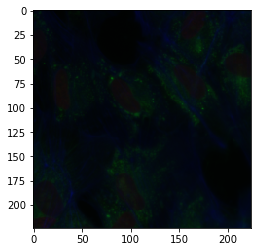

In [44]:
first_image_channels_1_3 = first_batch[0][0][0]
plt.imshow(first_image_channels_1_3, interpolation='nearest')

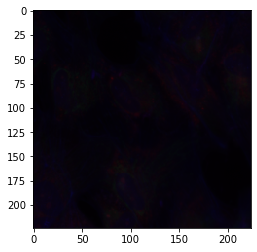

In [45]:
first_image_channels_4_6 = first_batch[0][1][0]
plt.imshow(first_image_channels_4_6, interpolation='nearest')

In [46]:
def create_model():
    effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
    site1 = Input(shape=(224,224,3))
    site2 = Input(shape=(224,224,3))
    x = effnet(site1)
    x = GlobalAveragePooling2D()(x)
    x = Model(inputs=site1, outputs=x)
    y = effnet(site2)
    y = GlobalAveragePooling2D()(y)
    y = Model(inputs=site2, outputs=y)
    combined = concatenate([x.output, y.output])
    z = Dropout(0.5)(combined)
    z = Dense(1108, activation='softmax')(z)
    model = Model(inputs=[x.input, y.input], outputs=z)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
    model.summary()
    
    return model

model = create_model()

2021-11-21 12:17:28.498530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-21 12:17:28.498868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-21 12:17:28.499143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-21 12:17:28.499523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-21 12:17:28.499533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1594] Could not ident

16719872/16705208 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 7, 7, 1280)   4049571     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (G

Training model

In [47]:
test_size = 0.025
batch_size = 32

In [48]:
train, val = train_test_split(train_data, test_size=test_size)

In [49]:
print(f"Training set size {len(train)}")
print(f"Validation set size {len(val)}")

Training set size 39
Validation set size 1


In [50]:
train_gen = ImgGen(train,batch_size=batch_size,preprocess=get_center_box,shuffle=True)
val_gen = ImgGen(val,batch_size=batch_size,preprocess=get_center_box,shuffle=True)

In [51]:
print(f"Training set batched size {len(train_gen)}")
print(f"Validation set batched size {len(val_gen)}")

Training set batched size 1
Validation set batched size 0


In [52]:
filepath = 'ModelCheckpoint_all.h5'

In [169]:
callback = [
        ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        ]

In [170]:
history = model.fit(train_gen, 
                              steps_per_epoch=len(train)//batch_size, 
                              epochs=1, 
                              verbose=1, 
                              validation_data=val_gen,
                              validation_steps=len(val)//batch_size,
                              callbacks=callback
                             )

  15/1112 [..............................] - ETA: 7:15:01 - loss: 7.1001 - accuracy: 0.0000e+00

KeyboardInterrupt: 